In [1]:
import pyart
import os
import sys
from glob import glob
import platform
import copy
import netCDF4
import datetime
import numpy as np
from matplotlib import pyplot as plt
from boto.s3.connection import S3Connection
import cartopy.crs as ccrs
from scipy.signal import medfilt2d

import tempfile

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#Now our nifty fetch script
#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime_t.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime_t.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    print(keys[index])
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

In [3]:
# Lets grab a radar volume from H. Maria
station = 'TJUA'
my_datetime = datetime.datetime(2017,9,6, 21, 48)
radar = get_radar_from_aws(station, my_datetime)

<Key: noaa-nexrad-level2,2017/09/06/TJUA/TJUA20170906_214755_V06>


In [4]:
print(radar.fields.keys())
radar_start_date = netCDF4.num2date(radar.time['data'][0],
        radar.time['units'])
print(radar_start_date)
ymd_string = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
hms_string = datetime.datetime.strftime(radar_start_date, '%H%M%S')
lats = radar.gate_latitude
lons = radar.gate_longitude

dict_keys(['cross_correlation_ratio', 'velocity', 'spectrum_width', 'differential_phase', 'differential_reflectivity', 'reflectivity'])
2017-09-06 21:47:55.982000


In [5]:
height = radar.gate_altitude
lats = radar.gate_latitude
lons = radar.gate_longitude
min_lon = lons['data'].min()
min_lat = lats['data'].min()
max_lat = lats['data'].max()
max_lon = lons['data'].max()

lat_lines = np.arange(min_lat, max_lat, 1)
lon_lines = np.arange(min_lon, max_lon, .1)
sw = 2

In [9]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [8,8])
# Setting projection and ploting the second tilt
projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                   central_longitude=radar.longitude['data'][0])

display.plot_ppi_map('differential_reflectivity', sweep = sw, vmin = -.5, vmax = 4,
                      min_lon = min_lon, max_lon = max_lon,
                      min_lat = min_lat, max_lat = max_lat,
                     resolution = '10m', projection = projection, fig = fig, cmap = 'pyart_HomeyerRainbow')

plt.savefig('fig1.png')
plt.close()

In [10]:
radar.add_field_like('differential_reflectivity', 'ZDR_smooth', \
                     radar.fields['differential_reflectivity']['data'].copy())

In [11]:
radar.fields.keys()

dict_keys(['cross_correlation_ratio', 'velocity', 'spectrum_width', 'differential_phase', 'differential_reflectivity', 'reflectivity', 'ZDR_smooth'])

In [12]:
radar.fields['ZDR_smooth']['data'] = medfilt2d(radar.fields['ZDR_smooth']['data'])
radar.fields['ZDR_smooth']['data'] = np.ma.masked_array(data = radar.fields['ZDR_smooth']['data'], mask = radar.fields['differential_reflectivity']['data'].mask)

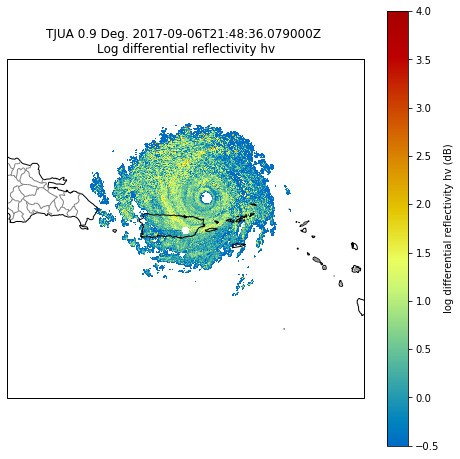

In [14]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [8,8])
# Setting projection and ploting the second tilt
projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                   central_longitude=radar.longitude['data'][0])

display.plot_ppi_map('ZDR_smooth', sweep = sw, vmin = -.5, vmax = 4,
                      min_lon = min_lon, max_lon = max_lon,
                      min_lat = min_lat, max_lat = max_lat,
                     resolution = '10m', projection = projection, fig = fig, cmap = 'pyart_HomeyerRainbow')

plt.savefig('fig2.png')